# Cluster analysis

 by Thibaut Perol

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import time
import csv

#set default plot characterstics and colors
from matplotlib import rcParams

#dark_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
dark_colors = ["#99D699", "#B2B2B2",
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (12, 9)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = "white"
rcParams['axes.titlesize'] = 20      
rcParams['axes.labelsize'] = 17.5
rcParams['xtick.labelsize'] = 15 
rcParams['ytick.labelsize'] = 15
rcParams['legend.fontsize'] = 17.5
rcParams['patch.edgecolor'] = 'none'
rcParams['grid.color']="gray"   
rcParams['grid.linestyle']="-" 
rcParams['grid.linewidth'] = 0.3
rcParams['grid.alpha']=1
rcParams['text.color'] = "444444"
rcParams['axes.labelcolor'] = "444444"
rcParams['ytick.color'] = "444444"
rcParams['xtick.color'] = "444444"

# Load the data frame
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog.csv',sep = '|')

# Show the first 5 earthquakes in the catalog and their features
eq_df.head()


/Users/thibaut/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


,id,origintime,latitude,longitude,depth,county,origin_src,prefmag,pmag_type,pmag_src,m3hz_ogs,md_ogs,geom,year_float
0,255,1980-01-05 07:11:31.21,35.586,-97.894,5,CANADIAN,OGS,1.9,M3Hz,OGS,1.9,1.7,0101000020E6100000F0A7C64B377958C05EBA490C02CB...,1980.130
1,256,1980-01-12 07:12:56.45,36.453,-97.642,5,GARFIELD,OGS,1.7,M3Hz,OGS,1.7,1.4,0101000020E61000000C022B87166958C0448B6CE7FB39...,1980.320
2,257,1980-02-03 00:46:30.05,33.994,-97.463,5,LOVE,OGS,2.2,M3Hz,OGS,2.2,2.0,0101000020E61000001283C0CAA15D58C0AC1C5A643BFF...,1980.920
3,258,1980-02-05 04:32:35.45,34.046,-97.451,5,LOVE,OGS,2.1,M3Hz,OGS,2.1,1.9,0101000020E6100000BE9F1A2FDD5C58C0D9CEF753E305...,1980.980
4,259,1980-03-09 03:57:10.56,35.100,-95.100,5,HASKELL,OGS,1.2,M3Hz,OGS,1.2,1.4,0101000020E61000006666666666C657C0CDCCCCCCCC8C...,1980.188


# Earthquake count versus time

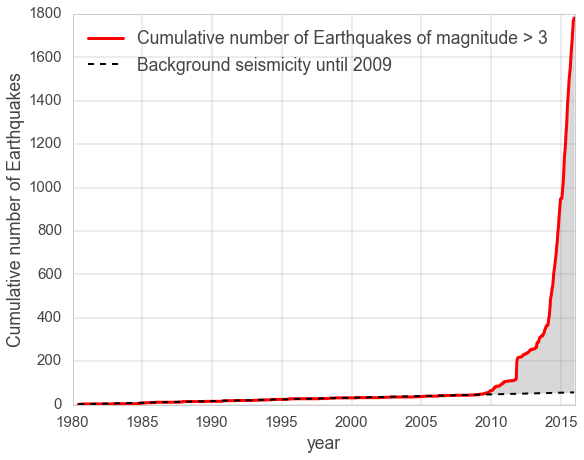

In [6]:
mask = eq_df['prefmag'] >=3
eq_count, base = np.histogram(eq_df[mask]['year_float'], bins = eq_df[mask].shape[0])
# plot the cumulative number of earthquakes of magnitude > 3
plt.figure(figsize = (9,7))
plt.plot(base[:-1], np.cumsum(eq_count), lw=3,c='r', label='Cumulative number of Earthquakes of magnitude > 3' )
mask_time = (eq_df['year_float'] < 2009) & (eq_df['prefmag'] >=3)
eq_2010, base_2010 = np.histogram(eq_df[mask_time]['year_float'], bins = eq_df[mask_time].shape[0])
# fit the earthquake count before 2009 with a 1st order polynomial
# this is the background seismicity rate
fit = np.polyfit(base_2010[:-1],np.cumsum(eq_2010),1)
fit_fn = np.poly1d(fit)
plt.plot(base[:-1],fit_fn(base[:-1]),'k--',label = 'Background seismicity until 2009')
# now fill in between
plt.fill_between(base[:-1], np.cumsum(eq_count), fit_fn(base[:-1]), color='grey', alpha = 0.3);
plt.xlim([1980,2016]);
plt.ylabel('Cumulative number of Earthquakes')
plt.xlabel('year')
plt.legend(loc =2);

# Earthquake clustering and microseismicity

In this section we will apply the DBSCAN algorithm to look at the clustering of earthquakes of magnitude higher than 3 (often felt by people) and the clustering of microseismicity (earthquake of magnitude lower than 2 not felt by people and not damaging).


# Rewrite the clustering algorithm

In [6]:
import pdb
def compute_dbscan(eq_df,mask,period, eps, min_samples):

    # Create a subset of the dataframe to work with
    subset = eq_df[mask]

    # ------------------------------------------------------------------------
    # COMPUTE DBSCAN
    # ------------------------------------------------------------------------

    X = []

    for (lat,longi) in zip(subset.latitude,subset.longitude):
        X.append((lat,longi))
    # implement the sparse matrix of distance
    X_dist = np.zeros((len(X),len(X)), dtype = np.float64)
    # select on index
    for i1 in range(len(X)):
        # loop over all the other indices
        for i2 in range(len(X)):
            #  now find the distance 
            if i1 < i2:
                # if i1 = i2 , distance = 0
                X_dist[i1,i2] = great_circle(X[i1],X[i2]).km
                # fill the symetric part of the matrix
                # since distance(x1, x2) = distance(x2, x1)
                X_dist[i2,i1] = X_dist[i1,i2]

    db = DBSCAN(eps= eps , min_samples= min_samples , metric = 'precomputed').fit(X_dist)
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    # note that noise is when the label is -1
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#     print('Estimated number of clusters: %d' % n_clusters_)
    
    return db, n_clusters_
    
def add_column_dataframe(eq_df,mask,eps,period, db):

    # ------------------------------------------------------------------------
    # APPEND COLUMN IN DATAFRAME
    # ------------------------------------------------------------------------

    col_name = 'cluster_' + period + '_eps_' + str(eps)


    eq_df[col_name] = np.zeros((eq_df.shape[0]))
    c = 0
    for i in range(eq_df.shape[0]):
        if mask[i]:
            # put the label in the corresponding column
            eq_df.loc[i,col_name] = db.labels_[c]
            c += 1
        else:
            eq_df.loc[i,col_name] =  - 10
            
    return eq_df


def plot_cluster_M(Period, distance_to_search_for_neighboring_points):
    
    eps = distance_to_search_for_neighboring_points
    
    if Period == 'before 2010':
        period = 'prior'
    elif Period == 'after 2010':
        period = 'post'
    col_name = 'cluster_' + period + '_eps_' + str(eps)    
    various_labels =  list(set(eq_df[col_name].values) - set([-10]))    
    
    # now plot
    fig = plt.figure(figsize=  (11,9))
    ax = fig.add_subplot(111)
    
    # ---
    # PLOT THE CLUSTERS
    # ---
    n_clusters_ = len(list(various_labels)) - 1
    for i in range(0,len(list(various_labels))):
        if list(various_labels)[i]!=-1:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]], \
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label=list(various_labels)[i],
                        color = sns.color_palette('hls',n_clusters_)[i], alpha =1, lw = 4);
        else:
            ax.scatter(eq_df.longitude[eq_df[col_name] == list(various_labels)[i]],\
                       eq_df.latitude[eq_df[col_name] == list(various_labels)[i]],label='noise',
                        color = 'k', alpha =0.1, lw=3);
    csfont = {'fontsize':25}
    ax.set_ylabel('Latitude',**csfont);
    ax.set_xlabel('Longitude',**csfont);
    ax.axis(**csfont)
    ax.set_title("Number of clusters: {}".format(n_clusters_),**csfont);

    # ---
    # PLOT SOME CITIES
    # ---


    # add a couple of cities
    cities = pd.read_csv('./tempdata/OK_cities.txt', sep = '\t')
    # add cities
    mask_towns = (cities.Name == 'Oklahoma City') | (cities.Name == 'Prague') | (cities.Name == 'Tulsa') \
        | (cities.Name == 'Ardmore') | (cities.Name == 'Stillwater') \
        | (cities.Name == 'Enid') | (cities.Name == 'Jones') \
        | (cities.Name == 'Cherookee') | (cities.Name == 'Perry') 
    cities_list = ['Oklahoma City','Prague','Tulsa', \
        'Ardmore','Stillwater', 'Enid', 'Jones', 'Cherookee', 'Perry']
    for city in cities_list:
        ax.annotate(city,\
         xy=(cities[cities.Name == city].Longitude.values[0] ,\
            cities[cities.Name == city].Latitude.values[0]),\
         size=20)
    ax.scatter(cities[mask_towns].Longitude.values[:],
        cities[mask_towns].Latitude.values[:], marker = '*', s= 100)
    ax.set_ylim([34,37])
    ax.set_xlim([-99.2,-96])
    ax.tick_params(labelsize=20)
    plt.show()
    
    return

In [5]:
# import libraries for DBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# import library for distance calculation
from geopy.distance import great_circle
# ------------------------------------------------------------------------
# LOAD THE DATA, GET A SUBSET MAGNITUDE > 3 AND COUNTY = LINCOLN
# ------------------------------------------------------------------------
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog.csv',sep = '|')
mask = (eq_df.prefmag >= 3.5) & (eq_df.prefmag < 2010)
# eps = the distance to search for neighboring points
# min_samples = the minimum the point required to create an individual cluster

for eps in range(5,30):
#     compute_dbscan(eq_df,mask,'prior', eps = eps, min_samples = 20) 
    db, n_clusters_ = compute_dbscan(eq_df,mask,'prior', eps = eps , min_samples = 20) 
    eq_df = add_column_dataframe(eq_df,mask,eps, 'prior', db)
    db, n_clusters_ = compute_dbscan(eq_df,mask,'post', eps = eps , min_samples = 20) 
    eq_df = add_column_dataframe(eq_df,mask,eps, 'post', db)

In [6]:
# Save data frame for future use
eq_df.to_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')

In [13]:
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
eq_df[ eq_df['cluster_prior_eps_8'] == 0].count()

id                      40
origintime              40
latitude                40
longitude               40
depth                   40
county                  38
origin_src              40
prefmag                 40
pmag_type               40
pmag_src                40
m3hz_ogs                 0
md_ogs                   0
geom                    40
year_float              40
cluster_prior_eps_5     40
cluster_post_eps_5      40
cluster_prior_eps_6     40
cluster_post_eps_6      40
cluster_prior_eps_7     40
cluster_post_eps_7      40
cluster_prior_eps_8     40
cluster_post_eps_8      40
cluster_prior_eps_9     40
cluster_post_eps_9      40
cluster_prior_eps_10    40
cluster_post_eps_10     40
cluster_prior_eps_11    40
cluster_post_eps_11     40
cluster_prior_eps_12    40
cluster_post_eps_12     40
                        ..
cluster_prior_eps_15    40
cluster_post_eps_15     40
cluster_prior_eps_16    40
cluster_post_eps_16     40
cluster_prior_eps_17    40
cluster_post_eps_17     40
c

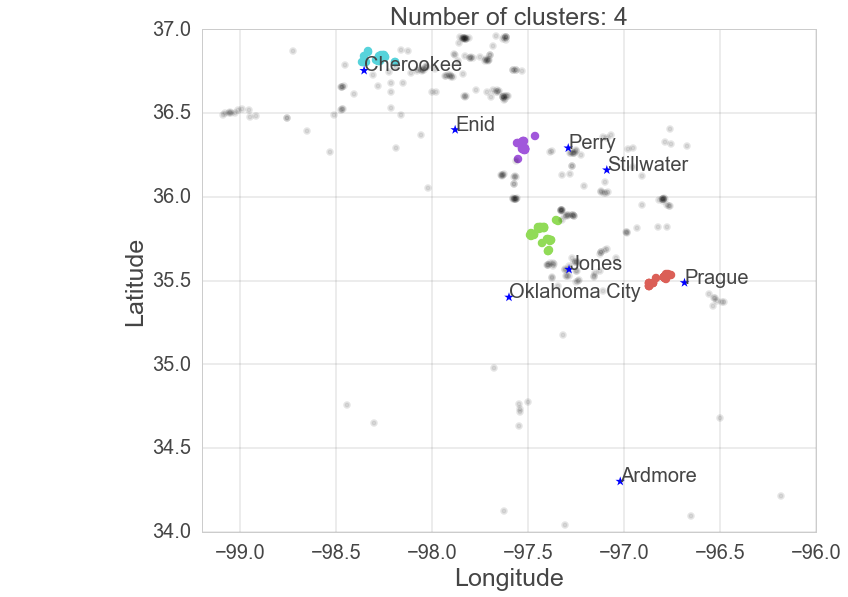

In [7]:
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
from IPython.html.widgets import interact
global eq_df
interact(plot_cluster_M, Period = ('before 2010', 'after 2010') ,distance_to_search_for_neighboring_points=(5,29,1));

# Grid algorithm for regression

In [3]:
# ------------------------------------------
# LOAD CLASSIC LIBRARIES
# ------------------------------------------

import numpy as np
import scipy as sp
import json
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from pyquery import PyQuery as pq
import requests
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import random
import json
import time
import csv
import itertools as it
import random
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)-10s) %(message)s',
                    )

# library for multithreading
import threading



# Default plotting
from matplotlib import rcParams

# Load package for linear model
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

def mask_region(df, region):
	mask_region = (df['latitude'] < region[0][1]) \
	        & (df['latitude'] >= region[0][0]) \
	        & (df['longitude'] < region[1][1]) \
	        & (df['longitude'] >= region[1][0])
	return mask_region

def partition_state(interval):

	# ------------------------------------------
	# PARTITION THE MAP INTO CELLS = CREATE THE GRID
	# ------------------------------------------

	# Make ranges 
	# Since all earthquakes are in Oklahoma we partition roughly
	# using the upper bound of the state limit
	xregions1 = np.arange(33.5, 37.0, interval)
	xregions2 = np.arange(33.5 + interval, 37.0 + interval, interval) 
	xregions = zip(xregions1, xregions2)
	yregions1 = np.arange(-103.0,-94. , interval) 
	yregions2 = np.arange(-103.0 + interval ,-94.0 + interval, interval)
	yregions = zip(yregions1, yregions2)

	# Create a dictionary with keys = (slice in long, slice in latitude)
	# value = number of the grid cell
	regions = it.product(xregions,yregions)
	locdict = dict(zip(regions, range(len(xregions)*len(yregions))))

	return locdict


def do_regression(eq_df, welldf, intervals, lock ,cv = 5, standardization = None):

	global best_grid_prior
	global best_grid_post

	for interval in intervals:

		# Get dictionary for the partitioned state
		locdict = partition_state(interval)

		# Filter by time
		eq_df_prior = eq_df[eq_df.year < 2010]
		welldf_prior = welldf[welldf.year < 2010]
		eq_df_post = eq_df[eq_df.year >= 2010]
		welldf_post = welldf[welldf.year >= 2010]



		X_prior = []
		X_post = []
		Y_prior = []
		Y_post = [] 
		### Start grid size loop here
		for region in locdict.keys():

			# generate dataframe for regression with data < 2010

			# add the number of quakes per region		
			Y_prior.append(eq_df_prior[mask_region(eq_df_prior,region)].count().values[0])
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_prior as [nb wells, volume]
			X_prior.append([welldf_prior[mask_region(welldf_prior,region)].count().values[0]
				, welldf_prior[mask_region(welldf_prior,region)].volume.sum()])

			# generate dataframe for regression with data >= 2010

			# add the number of quakes per region		
			Y_post.append(eq_df_post[mask_region(eq_df_post,region)].count().values[0])	
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_post as [nb wells, volume]
			X_post.append([welldf_post[mask_region(welldf_post,region)].count().values[0]
				, welldf_post[mask_region(welldf_post,region)].volume.sum()])

		X_prior = np.array(X_prior,dtype=np.float64)
		X_post = np.array(X_post,dtype=np.float64)
		Y_post = np.array(Y_post, dtype=np.float64).reshape(-1,1)
		Y_prior = np.array(Y_prior, dtype = np.float64).reshape(-1,1)

		# ------------------------------------------
		# DOING THE REGRESSION
		# ------------------------------------------
		# logging.debug(' For {} cells, Total number of quakes: prior {}, post {}'\
		# 		.format(len(locdict.keys()),sum(X_prior[:,0]), sum(X_post[:,0]) ))		

		reg_for = ['prior', 'post']
		for reg in reg_for:
			if reg == 'prior':
				X = X_prior
				Y = Y_prior
			elif reg == 'post':
				X = X_post
				Y = Y_post


			# --------------------
			# SPLIT INTO TRAIN AND TEST
			# --------------------

			# Split in train - test 
			X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


			# --------------------
			# STANDARDIZATION OF THE DATA -- SCALING
			# --------------------

			if standardization == 'scaler':

				scaler = preprocessing.StandardScaler().fit(X_train)
				X_train = scaler.fit_transform(X_train)
				X_test = scaler.transform(X_test)
				y_train = scaler.fit_transform(y_train)
				y_test = scaler.transform(y_test)

			elif standardization == 'MinMaxScaler':
				min_max_scaler = preprocessing.MinMaxScaler()
				X_train = min_max_scaler.fit_transform(X_train)
				X_test = min_max_scaler.transform(X_test)
				y_train = min_max_scaler.fit_transform(y_train)
				y_test = min_max_scaler.transform(y_test)
			else:
				pass


			# --------------------
			# OPTIMIZE CLASSIFIER WITH RIDGE REGRESSION
			# AND ORDINARY LEAST SQUARE REGRESSION
			# no need for Lasso because only 2 features
			# --------------------


			# # Using Ordinary Least Square Regression
			# clf = linear_model.LinearRegression()
			# clf.fit(X_train, y_train)
			# logging.debug('For {} cells the score is {}'.format(len(locdict.keys()),clf.score(X_test, y_test)))


			# # Using Ridge Regression and cross-validation
			# # doing the selection manually
			# # uncomment this part to check it matches the next paragraph
			# clf = linear_model.Ridge()
			# parameters = {'alpha': [0.1, 0.5]}
			# gs = GridSearchCV(clf, param_grid=parameters, cv=5)
			# gs.fit(X_train, y_train)

			# best = gs.best_estimator_
			# best.fit(X_train, y_train)
			# logging.debug('For {} cells the score of manual Ridge is {}'.format(len(locdict.keys()),best.score(X_test, y_test)))



			# Using Ridge Regression with built-in cross validation
			# of the alpha parameters
			# note that alpha = 0 corresponds to the Ordinary Least Square Regression
			clf = linear_model.RidgeCV(alphas=[0.0, 0.1, 1, 10.0, 100.0, 1e3,1e4 ,1e5], cv = cv)
			clf.fit(X_train, y_train)

			logging.debug('{}: For {} cells the score of RidgeCV is {} with alpha = {}'\
				.format(reg,len(locdict.keys()),clf.score(X_test, y_test),clf.alpha_))

			with lock:
				if reg == 'prior': 
					best_grid_prior.append([clf,clf.score(X_test, y_test),interval])
				elif reg == 'post':
					best_grid_post.append([clf,clf.score(X_test, y_test),interval])



	return

# ------------------------------------------
# LOAD DATAFRAMES
# ------------------------------------------
# Load the earthquakes datafram 
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
# filter to keep magnitude >= 3
eq_df  = eq_df[eq_df.prefmag >= 3.0]
# for ease add column year
eq_df['year'] = map(lambda x: int(x), eq_df['year_float'])


# Load the wells dataframe.  
welldf = pd.DataFrame.from_csv('tempdata/wells_data.csv')

# define the intervals
# intervals = [0.05, 0.1,0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]
intervals = [0.5,0.8,0.9, 1.0, 1.5]

# define the number of threads
num_threads = 4

# split randomely the letters in batch for the various threads
all_batch = []
size_batch = len(intervals) / num_threads
for i in range(num_threads-1):
    batch_per_threads = random.sample(intervals,size_batch)
    all_batch.append(batch_per_threads)
    # new set
    intervals  = list(set(intervals) - set(batch_per_threads))
# now get the rest
all_batch.append(intervals)
print('look at all_batch {}'.format(all_batch))

best_grid_prior = []
best_grid_post = []

global best_grid_prior
global best_grid_post

# Vary the standardization and find optimum
for standardization in ['None','scaler','MinMaxScaler'] :
    # parallelize the loop of interval
    threads = []
    lock = threading.Lock()
    for thread_id in range(num_threads):
        interval = all_batch[thread_id]
        t = threading.Thread(target = do_regression, \
            args = (eq_df, welldf, interval, lock ,5,standardization))
        threads.append(t)

    print 'Starting multithreading'
    map(lambda t:t.start(), threads)
    map(lambda t: t.join(), threads)


best_score_prior = [[c[1],c[2]] for c in best_grid_prior]
best_score_prior = np.array(best_score_prior)
best_index_prior = np.where(best_score_prior[:,0] == max(best_score_prior[:,0]))[0][0]
print('Best classifier <2010 is for alpha ={}'.format(best_grid_prior[best_index_prior][0].alpha_))
print('Coefs <2010 are ={}'.format(best_grid_prior[best_index_prior][0].coef_))
print('R^2 <2010 = {}'.format(best_grid_prior[best_index_prior][1]))
print('Best interval <2010 is {}'.format(best_grid_prior[best_index_prior][2]))


best_score_post = [[c[1],c[2]] for c in best_grid_post]
best_score_post = np.array(best_score_post)
best_index_post = np.where(best_score_post[:,0] == max(best_score_post[:,0]))[0][0]
print('Best classifier >= 2010 is for alpha ={}'.format(best_grid_post[best_index_post][0].alpha_))
print('Coefs >= 2010 are ={}'.format(best_grid_post[best_index_post][0].coef_))
print('R^2 >= 2010 = {}'.format(best_grid_post[best_index_post][1]))
print('Best interval >= 2010 is {}'.format(best_grid_post[best_index_post][2]))

look at all_batch [[0.9], [1.0], [0.5], [1.5, 0.8]]
Starting multithreading
Starting multithreading


KeyboardInterrupt: 

# Try regression per year

In [42]:
# ------------------------------------------
# LOAD DATAFRAMES
# ------------------------------------------
# Load the earthquakes datafram 
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
# filter to keep magnitude >= 3
eq_df  = eq_df[eq_df.prefmag >= 3.0]
# for ease add column year
eq_df['year'] = map(lambda x: int(x), eq_df['year_float'])


# Load the wells dataframe.  
welldf = pd.DataFrame.from_csv('tempdata/wells_data.csv')
    
interval = 0.1

# Get dictionary for the partitioned state
locdict = partition_state(interval)

# Filter by time
eq_df_prior = eq_df[eq_df.year < 2010]
welldf_prior = welldf[welldf.year < 2010]
eq_df_post = eq_df[eq_df.year >= 2010]
welldf_post = welldf[welldf.year >= 2010]

for i in range(len(locdict.keys())):
    region = locdict.keys()[i]
    if len(eq_df_post[mask_region(eq_df_post,region)].groupby(['year'])) > 2:
           print i

5
107
123
344
576
597
706
758
779
1190
1248
1253
1453
1552
1682
1770
2025
2074
2244
2331
2376
2411
2446
2498
2515
2589
2710
2929


In [67]:
# for i in range(len(locdict.keys())):
region = locdict.keys()[1190]
print eq_df_post[mask_region(eq_df_post,region)].groupby(['year']).count().index.values
print eq_df_post[mask_region(eq_df_post,region)].groupby(['year']).count().id.values

[2010 2011 2013 2014 2015]
[6 4 5 4 2]


In [70]:
welldf_post[mask_region(welldf_post,region)].groupby(['year']).count().head()

,API_COUNTY,API_NUMBER,LEASE_NAME,WELL_NUMBER,latitude,longitude,FLUID_TYPE,PACKERDPTH,volume
year,,,,,,,,,
2010,3,3,3,3,3,3,3,3,3


# REGRESSIONS

In this section we compare various regression models and compare with the baseline model. First let us load the earthquakes catalog and the wells catalog. We also initialize a dictionary *results_dic* in which we will store the results of all the regressions.

In [ ]:
# ------------------------------------------
# LOAD DATAFRAMES
# ------------------------------------------
# Load the earthquakes dataframe
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
# filter to keep only magnitude >= 3
eq_df  = eq_df[eq_df.prefmag >= 3.0]
# for ease add column year
eq_df['year'] = map(lambda x: int(x), eq_df['year_float'])

# Load the wells dataframe.  
welldf = pd.DataFrame.from_csv('tempdata/wells_data.csv')

# define the number of threads for the computation
# please optimize according to your number of cores
num_threads = 4

# initialize the dictionary in which we store the results of all  the regressions
results_dic= {}

We will also set up a bunch of functions detailed here.

In [2]:
import pickle
import itertools as it

# library for multithreading
import threading

# library for print messages from each thread
import logging
logging.basicConfig(level=logging.DEBUG,
                    format='[%(levelname)s] (%(threadName)-10s) %(message)s',
                    )

# for time split
import datetime

# Load package for linear model
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

# import library for calculating the distance
from geopy.distance import great_circle

Here is a function that evaluate the time in seconds between earthquakes from a dataframe *df*.

In [ ]:
def get_hours_between(df):
    dates=[]
    origintimes = df.origintime.values
    for date in origintimes:
        year, month, day = date.split('-')
        day, hour = day.split(' ')
        hour, minute, second = hour.split(':')
        if len(second.split('.'))==2:
            second, microsecond = second.split('.')
        elif len(second.split('.'))==1:
            microsecond=0
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour), int(minute), 
                                       int(second), int(microsecond)))
    dates=sorted(dates)
    intertimes =[]
    for i in range(1,len(dates)):
        delta = dates[i] - dates[i-1]
        delta = delta.total_seconds()/3600
        intertimes .append(delta)
    return intertimes * 60

Here is a function that calculate the distance between two points for which we provide the latitude and the longitude.

In [ ]:
def get_furthest_distance(eq_df, mask, centroid):
	furthest_point = None
	furthest_dist = None

	for point0, point1 in zip(eq_df[mask].latitude,eq_df[mask].longitude):
		point = (point0, point1)
		dist = great_circle( centroid, point ).km
		if (furthest_dist is None) or (dist > furthest_dist):
			furthest_dist = dist
			furthest_point = point
	return furthest_dist 

Here is a function that finds the center of mass of a catalog of events. We pass the large dataframe with all earthquakes and pass un mask that corresponds to a cluster of earthquakes predefined from an clustering algorithm (detailed later).

In [ ]:
def cluster_centroid(eq_df, mask):
	n = eq_df[ mask].shape[0]
	sum_lon = eq_df[ mask].longitude.sum()
	sum_lat = eq_df[mask].latitude.sum()
	return (sum_lat/n, sum_lon/n )

Here we pass the dataframe with the well locations and their volume. We also provide the center of mass of a cluster and the maximum radius of the cluster within which we find the number of wells from *welldf* and the total volume of water injected in this region.

In [ ]:
def get_cluster_nwells_volume(welldf, centroid, radius):
	
	n_wells = 0
	volume = 0

	for (i, coords) in enumerate(zip(welldf.latitude,welldf.longitude)):
		if great_circle((coords[0],coords[1]),centroid ) < radius:
			n_wells += 1
			volume += welldf.loc[i, 'volume']

	return [n_wells, volume]

Here we define a function that generate a mask for the loading a specific results of the clustering algorithm written in the dataframe.

In [ ]:
def mask_cluster(df, period, eps,  cluster_id): 
    
    ''' INPUT:
    df = dataframe for which we want to create a mask
    period = 'post' or 'prior' for after or before 2010
    eps = distance between events for the DBSCAN algorithm
    cluster_id = id of the cluster for which we want to find the mask
    
    example: we want cluster 1 from the catalog < 2010 found by DBSCAN for 
            eps = 8:  mask_cluster(eq_df, 'prior', 8,  1)
    '''

	# reconstruct the column name
	col_name = 'cluster_' + period + '_eps_' + str(eps)

	mask_cluster = df[ col_name  ] == cluster_id

	return mask_cluster

Here is a function that creates a mask for a region defined by bounds in latitude and longitude. The various regions are ouput of the *partition_state* function that partition Oklahoma state into squares of a given length. 

In [ ]:
def mask_region(df, region):
        
	mask_region = (df['latitude'] < region[0][1]) \
	        & (df['latitude'] >= region[0][0]) \
	        & (df['longitude'] < region[1][1]) \
	        & (df['longitude'] >= region[1][0])
	return mask_region

Here is the function that partition OK state into cells. We provide to the function an interval to split the minimum and maximum latitude and longitude. The ouput of the function is a dictionary with keys the bounds of the cells as ( (minimum latitude, maximum latitude), (minimum longitude, maximum longitude) ). 

In [ ]:
def partition_state(interval):

	# ------------------------------------------
	# PARTITION THE MAP INTO CELLS = CREATE THE GRID
	# ------------------------------------------

	# Make ranges 
	# Since all earthquakes are in Oklahoma we partition roughly
	# using the upper bound of the state limit
	xregions1 = np.arange(33.5, 37.0, interval)
	xregions2 = np.arange(33.5 + interval, 37.0 + interval, interval) 
	xregions = zip(xregions1, xregions2)
	yregions1 = np.arange(-103.0,-94. , interval) 
	yregions2 = np.arange(-103.0 + interval ,-94.0 + interval, interval)
	yregions = zip(yregions1, yregions2)

	# Create a dictionary with keys = (slice in long, slice in latitude)
	# value = number of the grid cell
	regions = it.product(xregions,yregions)
	locdict = dict(zip(regions, range(len(xregions)*len(yregions))))

	return locdict

## Ridge regression

Once the predictor and response vectors are assembled (see details in the next subsection), we **split into a training and a test set**. The size of the test set is set to 1/3 of the total size of the sample. This is done using the *train_test_split* function from scikit-learn. We then try various **standardization of the data**. The first standardization tested transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation. This is done using the *preprocessing.StandardScaler()* method. We also tested the *preprocessing.MinMaxScaler()* method that simply rescale the data from 0 to 1. Finally the third method does not transform the initial data. Finally we implement a **ridge regression** with **cross-validation** of the alpha parameter (parameter used for the L2 regularization). Since we only have two features we don't bother doing a Lasso regression.

In [ ]:
def do_regression(X,Y,reg,locdict,lock,cv, standardization):

	# --------------------
	# SPLIT INTO TRAIN AND TEST
	# --------------------

	# Split in train - test 
	X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


	# --------------------
	# STANDARDIZATION OF THE DATA -- SCALING
	# --------------------

	if standardization == 'scaler':

		scaler = preprocessing.StandardScaler().fit(X_train)
		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)
		y_train = scaler.fit_transform(y_train)
		y_test = scaler.transform(y_test)

	elif standardization == 'MinMaxScaler':
		min_max_scaler = preprocessing.MinMaxScaler()
		X_train = min_max_scaler.fit_transform(X_train)
		X_test = min_max_scaler.transform(X_test)
		y_train = min_max_scaler.fit_transform(y_train)
		y_test = min_max_scaler.transform(y_test)
	else:
		pass


	# --------------------
	# OPTIMIZE CLASSIFIER WITH RIDGE REGRESSION
	# AND ORDINARY LEAST SQUARE REGRESSION
	# --------------------


	# # Using Ordinary Least Square Regression
	# clf = linear_model.LinearRegression()
	# clf.fit(X_train, y_train)
	# logging.debug('For {} cells the score is {}'.format(len(locdict.keys()),clf.score(X_test, y_test)))


	# # Using Ridge Regression and cross-validation
	# # doing the selection manually
	# # uncomment this part to check it matches the next paragraph
	# clf = linear_model.Ridge()
	# parameters = {'alpha': [0.1, 0.5]}
	# gs = GridSearchCV(clf, param_grid=parameters, cv=5)
	# gs.fit(X_train, y_train)

	# best = gs.best_estimator_
	# best.fit(X_train, y_train)
	# logging.debug('For {} cells the score of manual Ridge is {}'.format(len(locdict.keys()),best.score(X_test, y_test)))



	# Using Ridge Regression with built-in cross validation
	# of the alpha parameters
	# note that alpha = 0 corresponds to the Ordinary Least Square Regression
	clf = linear_model.RidgeCV(alphas=[0.0, 0.1, 1, 10.0, 100.0, 1e3,1e4 ,1e5], cv = cv)
	clf.fit(X_train, y_train)


	return clf, X_test, y_test

## Regression and parallelization of the algorithm

In this section we present the various type of regressions done in this study. 

In [2]:
# ------------------------------------------
# LOAD DATAFRAMES
# ------------------------------------------
# Load the earthquakes dataframe
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
# filter to keep only magnitude >= 3
eq_df  = eq_df[eq_df.prefmag >= 3.0]
# for ease add column year
eq_df['year'] = map(lambda x: int(x), eq_df['year_float'])

# Load the wells dataframe.  
welldf = pd.DataFrame.from_csv('tempdata/wells_data.csv')

# define the number of threads for the computation
# please optimize according to your number of cores
num_threads = 4

# initialize the dictionary in which we store the results of all  the regressions
results_dic= {}

NameError: name 'pd' is not defined

### Predicting the number of earthquakes

#### Regression over a regular grid

We use here two methods. The first one creates square cells over the OK state. On which cell we evaluate the number of earthquakes (fed into the response vector) and the number of disposal wells as well as the total volume of water injected (these two features are appended into the predictor vector). Doing this for all the cells, we do a regression: 
$$ number \,of\, earthquakes \propto number\, of\, wells + total \,volume\, injected $$

The function *do_grid_regresssion* assemble the predictor and response vectors, $X$ and $Y$ that are fed to the *do_regression*. We do the regression for the **data prior 2010 and post 2010**. The score of the classifier ($R^2$, the coefficient of determination) is appended to *best_grid_prior* and *best_grid_prior* for data prior 2010 and post 2010 respectively.

In [ ]:
def do_grid_regression(eq_df, welldf, intervals, lock ,cv = 5, standardization = None):

	global best_grid_prior
	global best_grid_post

	for interval in intervals:

		# Get dictionary for the partitioned state
		locdict = partition_state(interval)

		# Filter by time
		eq_df_prior = eq_df[eq_df.year < 2010]
		welldf_prior = welldf[welldf.year < 2010]
		eq_df_post = eq_df[eq_df.year >= 2010]
		welldf_post = welldf[welldf.year >= 2010]



		X_prior = []
		X_post = []
		Y_prior = []
		Y_post = [] 
		### Start grid size loop here
		for region in locdict.keys():

			# generate dataframe for regression with data < 2010

			# add the number of quakes per region		
			Y_prior.append(eq_df_prior[mask_region(eq_df_prior,region)].count().values[0])
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_prior as [nb wells, volume]
			X_prior.append([welldf_prior[mask_region(welldf_prior,region)].count().values[0]
				, welldf_prior[mask_region(welldf_prior,region)].volume.sum()])

			# generate dataframe for regression with data >= 2010

			# add the number of quakes per region		
			Y_post.append(eq_df_post[mask_region(eq_df_post,region)].count().values[0])	
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_post as [nb wells, volume]
			X_post.append([welldf_post[mask_region(welldf_post,region)].count().values[0]
				, welldf_post[mask_region(welldf_post,region)].volume.sum()])

		X_prior = np.array(X_prior,dtype=np.float64)
		X_post = np.array(X_post,dtype=np.float64)
		Y_post = np.array(Y_post, dtype=np.float64).reshape(-1,1)
		Y_prior = np.array(Y_prior, dtype = np.float64).reshape(-1,1)

		# ------------------------------------------
		# DOING THE REGRESSION
		# ------------------------------------------
		# logging.debug(' For {} cells, Total number of quakes: prior {}, post {}'\
		# 		.format(len(locdict.keys()),sum(X_prior[:,0]), sum(X_post[:,0]) ))		

		reg_for = ['prior', 'post']
		for reg in reg_for:
			if reg == 'prior':
				X = X_prior
				Y = Y_prior
			elif reg == 'post':
				X = X_post
				Y = Y_post

			clf, X_test, y_test  = do_regression(X,Y,reg,locdict,lock, cv ,standardization)	

			logging.debug('{}: For {} cells the score of RidgeCV is {} with alpha = {}'\
				.format(reg,len(locdict.keys()),clf.score(X_test, y_test),clf.alpha_))

			with lock:
				if reg == 'prior': 
					best_grid_prior.append([clf,clf.score(X_test, y_test),interval])
				elif reg == 'post':
					best_grid_post.append([clf,clf.score(X_test, y_test),interval])

	return

In [ ]:
def do_cluster_regression(eq_df, welldf, eps_s, lock ,cv = 5, standardization = None):

	global best_grid_prior
	global best_grid_post

	# Filter by time
	welldf_prior = welldf[welldf.year < 2010]
	welldf_prior.reset_index(inplace=True)
	welldf_post = welldf[welldf.year >= 2010]
	welldf_post.reset_index(inplace=True)

	for eps in eps_s:

		X_prior = []
		X_post = []
		Y_prior = []
		Y_post = [] 
		total_prior = []
		total_post = []

		logging.debug('eps {} from batch {}, standardization method: {}'\
		.format(eps, eps_s,standardization))


		# DO THIS FOR PRIOR

		# find the list of clusters
		col_name = 'cluster_' + 'prior' + '_eps_' + str(eps)
		clusters = list(set(eq_df[col_name].values) - set([-10]))
		# this is for the clusters that are not noise
		for cluster_id in clusters:
			# get mask for the cluster_id
			mask = mask_cluster(eq_df, 'prior', eps,  cluster_id)
			Y_prior_append = get_hours_between(  eq_df[ mask] )   
			for y in Y_prior_append:
				Y_prior.append(y)

			# find the centroid of the cluster
			centroid = cluster_centroid(eq_df, mask)
			# find the largest radius = largest distance between centroid and points
			# in the cluster
			radius = get_furthest_distance(eq_df, mask, centroid)
			# find the numbe of wells and volume within this radius
			X_prior_append=get_cluster_nwells_volume(welldf_prior, centroid, radius)
			total_prior.append(X_prior_append)
			for i in range(len(Y_prior_append)):			
					X_prior.append(X_prior_append)	

		# add the interarrival for the events classified as noise
		cluster_id = -1
		# ------
		mask = mask_cluster(eq_df, 'prior', eps,  cluster_id)
		Y_prior_append = get_hours_between(  eq_df[ mask] )   
		for y in Y_prior_append:
			Y_prior.append(y)

		# find the volume
		total_prior = np.array(total_prior)
		X_prior_append=[welldf_prior.count().values[0] - sum(total_prior[:,0]) , welldf_prior.volume.sum() - sum(total_prior[:,1]) ]
		for i in range(len(Y_prior_append)):			
				X_prior.append(X_prior_append)	

		#------

		# DO THIS FOR POST

		# find the list of clusters
		col_name = 'cluster_' + 'post' + '_eps_' + str(eps)
		clusters = list(set(eq_df[col_name].values) - set([-10]))
		for cluster_id in clusters:
			# get mask for the cluster_id
			mask = mask_cluster(eq_df, 'post', eps,  cluster_id)
			Y_post_append = get_hours_between( eq_df[ mask] )
			for y in Y_post_append:
				Y_post.append(y)

			# find the centroid of the cluster
			centroid = cluster_centroid(eq_df, mask)
			# find the largest radius = largest distance between centroid and points
			# in the cluster
			radius = get_furthest_distance(eq_df, mask, centroid)
			# find the numbe of wells and volume within this radius
			X_post_append=get_cluster_nwells_volume(welldf_post, centroid, radius) 
			total_post.append(X_post_append)
			for i in range(len(Y_post_append)):
				X_post.append(X_post_append)

		# add the interarrival for the events classified as noise
		cluster_id = -1
		# ------
		mask = mask_cluster(eq_df, 'post', eps,  cluster_id)
		Y_post_append = get_hours_between(  eq_df[ mask] )   
		for y in Y_post_append:
			Y_post.append(y)

		# find the volume
		total_post = np.array(total_post)
		X_post_append=[welldf_post.count().values[0] - sum(total_post[:,0]) , welldf_post.volume.sum() - sum(total_post[:,1]) ]
		for i in range(len(Y_post_append)):			
				X_post.append(X_post_append)	

		#------

		X_prior = np.array(X_prior,dtype=np.float64)
		X_post = np.array(X_post,dtype=np.float64)		

		# ------------------------------------------
		# DOING THE REGRESSION
		# ------------------------------------------
		# logging.debug(' For {} cells, Total number of quakes: prior {}, post {}'\
		# 		.format(len(locdict.keys()),sum(X_prior[:,0]), sum(X_post[:,0]) ))		

		reg_for = ['prior', 'post']
		for reg in reg_for:
			if reg == 'prior':
				X = X_prior
				Y = Y_prior
			elif reg == 'post':
				X = X_post
				Y = Y_post


			# --------------------
			# SPLIT INTO TRAIN AND TEST
			# --------------------

			# Split in train - test 
			X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


			# --------------------
			# STANDARDIZATION OF THE DATA -- SCALING
			# --------------------

			if standardization == 'scaler':

				scaler = preprocessing.StandardScaler().fit(X_train)
				X_train = scaler.fit_transform(X_train)
				X_test = scaler.transform(X_test)
				y_train = scaler.fit_transform(y_train)
				y_test = scaler.transform(y_test)

			elif standardization == 'MinMaxScaler':
				min_max_scaler = preprocessing.MinMaxScaler()
				X_train = min_max_scaler.fit_transform(X_train)
				X_test = min_max_scaler.transform(X_test)
				y_train = min_max_scaler.fit_transform(y_train)
				y_test = min_max_scaler.transform(y_test)
			else:
				pass


			# --------------------
			# OPTIMIZE CLASSIFIER WITH RIDGE REGRESSION
			# AND ORDINARY LEAST SQUARE REGRESSION
			# --------------------

			# Using Ridge Regression with built-in cross validation
			# of the alpha parameters
			# note that alpha = 0 corresponds to the Ordinary Least Square Regression
			clf = linear_model.RidgeCV(alphas=[0.0, 0.1, 1, 10.0, 100.0, 1e3,1e4 ,1e5], cv =cv)

			clf.fit(X_train, y_train)
			logging.debug('{}: For eps = {}, score : {}'.format(reg,eps,clf.score(X_test, y_test)))

			with lock:
				if reg == 'prior': 
					best_grid_prior.append([clf,clf.score(X_test, y_test), eps])
				elif reg == 'post':
					best_grid_post.append([clf,clf.score(X_test, y_test),eps])		


	return

def do_grid_interarrival_regression(eq_df, welldf, intervals, lock ,cv = 5, standardization = None):

	global best_grid_prior
	global best_grid_post

	for interval in intervals:
		# Get dictionary for the partitioned state
		locdict = partition_state(interval)

		# Filter by time
		eq_df_prior = eq_df[eq_df.year < 2010]
		welldf_prior = welldf[welldf.year < 2010]
		welldf_prior.reset_index(inplace=True)
		welldf_post = welldf[welldf.year >= 2010]
		welldf_post.reset_index(inplace=True)
		eq_df_post = eq_df[eq_df.year >= 2010]


		X_prior = []
		X_post = []
		Y_prior = []
		Y_post = [] 

		for region in locdict.keys():

			# DO THIS FOR PRIOR

			# get mask for the cluster_id
			mask = mask_region(eq_df_prior,region)
			Y_prior_append = get_hours_between(  eq_df_prior[ mask] ) 
			if len(Y_prior_append) != 0:
				Y_prior_append = [1.0/y for y in Y_prior_append]
			else:
				Y_prior_append = [0.0]  
			for y in Y_prior_append:
				Y_prior.append(y)
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_prior as [nb wells, volume]
			X_prior_append = [welldf_prior[mask_region(welldf_prior,region)].count().values[0]
				, welldf_prior[mask_region(welldf_prior,region)].volume.sum()]

			for i in range(len(Y_prior_append)):			
					X_prior.append(X_prior_append)	


			# DO THIS FOR POST

			# get mask for the cluster_id
			mask = mask_region(eq_df_post,region)
			Y_post_append = get_hours_between( eq_df_post[ mask] )
			# logging.debug('Y_post {}'.format(Y_post))
			if len(Y_post_append) != 0:
				Y_post_append = [1.0/y for y in Y_post_append if y!=0]
			else:
				Y_post_append = [0.0] 			
			for y in Y_post_append:
				Y_post.append(y)
			# add the number of wells per region
			# add the total volume injected per region
			# add them with into X_post as [nb wells, volume]
			X_post_append = [welldf_post[mask_region(welldf_post,region)].count().values[0]
				, welldf_post[mask_region(welldf_post,region)].volume.sum()]

			for i in range(len(Y_post_append)):
				X_post.append(X_post_append)

		X_prior = np.array(X_prior,dtype=np.float64)
		X_post = np.array(X_post,dtype=np.float64)		
		Y_post = np.array(Y_post, dtype=np.float64).reshape(-1,1)
		Y_prior = np.array(Y_prior, dtype = np.float64).reshape(-1,1)


		# ------------------------------------------
		# DOING THE REGRESSION
		# ------------------------------------------
		# logging.debug(' For {} cells, Total number of quakes: prior {}, post {}'\
		# 		.format(len(locdict.keys()),sum(X_prior[:,0]), sum(X_post[:,0]) ))		

		reg_for = ['prior', 'post']
		for reg in reg_for:
			if reg == 'prior':
				X = X_prior
				Y = Y_prior
			elif reg == 'post':
				X = X_post
				Y = Y_post

			clf, X_test, y_test = do_regression(X,Y,reg,locdict,lock, cv ,standardization)


			logging.debug('{}: For {} cells the score of RidgeCV is {} with alpha = {}'\
				.format(reg,len(locdict.keys()),clf.score(X_test, y_test),clf.alpha_))

			with lock:
				if reg == 'prior': 
					best_grid_prior.append([clf,clf.score(X_test, y_test), interval])
				elif reg == 'post':
					best_grid_post.append([clf,clf.score(X_test, y_test),interval])		


	return


def split_in_batch(intervals):

    # split randomely the letters in batch for the various threads
	all_batch = []
	size_batch = len(intervals) / num_threads
	for i in range(num_threads-1):
		batch_per_threads = random.sample(intervals,size_batch)
		all_batch.append(batch_per_threads)
		# new set
		intervals  = list(set(intervals) - set(batch_per_threads))
	# now get the rest
	all_batch.append(intervals)
	print('look at all_batch {}'.format(all_batch))

	return all_batch

def print_best_score_append_dictionary(reg_type):

	best_score_prior = [[c[1],c[2]] for c in best_grid_prior]
	best_score_prior = np.array(best_score_prior)
	best_index_prior = np.where(best_score_prior[:,0] == max(best_score_prior[:,0]))[0][0]
	print('Best classifier <2010 is for alpha ={}'.format(best_grid_prior[best_index_prior][0].alpha_))
	print('Coefs <2010 are ={}'.format(best_grid_prior[best_index_prior][0].coef_))
	print('R^2 <2010 = {}'.format(best_grid_prior[best_index_prior][1]))

	prior_dic = {'coefs':best_grid_prior[best_index_prior][0].coef_ , 'r2': best_grid_prior[best_index_prior][1]}

	if reg_type == 'grid':
		prior_dic['interval'] = best_grid_prior[best_index_prior][2]
		print('Best interval <2010 is {}'.format(best_grid_prior[best_index_prior][2]))
	elif reg_type == 'cluster':
		prior_dic['eps'] = best_grid_prior[best_index_prior][2]
		print('Best eps <2010 is {}'.format(best_grid_prior[best_index_prior][2]))



	best_score_post = [[c[1],c[2]] for c in best_grid_post]
	best_score_post = np.array(best_score_post)
	best_index_post = np.where(best_score_post[:,0] == max(best_score_post[:,0]))[0][0]
	print('Best classifier >= 2010 is for alpha ={}'.format(best_grid_post[best_index_post][0].alpha_))
	print('Coefs >= 2010 are ={}'.format(best_grid_post[best_index_post][0].coef_))
	print('R^2 >= 2010 = {}'.format(best_grid_post[best_index_post][1]))

	post_dic = {'coefs':best_grid_post[best_index_post][0].coef_ , 'r2': best_grid_post[best_index_post][1]}

	if reg_type == 'grid':
		post_dic['interval'] = best_grid_post[best_index_post][2]
		print('Best interval >= 2010 is {}'.format(best_grid_post[best_index_post][2]))
	elif reg_type == 'cluster':
		post_dic['eps'] = best_grid_post[best_index_post][2]
		print('Best eps >= 2010 is {}'.format(best_grid_post[best_index_post][2]))


	return prior_dic, post_dic

In [3]:
# ------------------------------------------
# LOAD DATAFRAMES
# ------------------------------------------
# Load the earthquakes datafram 
eq_df = pd.DataFrame.from_csv('./tempdata/earthquakes_catalog_treated.csv',sep = '|')
# filter to keep magnitude >= 3
eq_df  = eq_df[eq_df.prefmag >= 3.0]
# for ease add column year
eq_df['year'] = map(lambda x: int(x), eq_df['year_float'])


# Load the wells dataframe.  
welldf = pd.DataFrame.from_csv('tempdata/wells_data.csv')



# define the number of threads
num_threads = 4

# initialize the dictionary in which we store the results
results_dic= {}

In [5]:

# ------------------------------------------
# GRID REGRESSION
# ------------------------------------------	

best_grid_prior = []
best_grid_post = []

# define the intervals
intervals = [0.05, 0.1,0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]
# intervals = [0.4, 0.5, 0.8,0.9, 1.0, 1.5]


   # split randomely the letters in batch for the various threads
all_batch = split_in_batch(intervals)

# Vary the standardization and find optimum
for standardization in ['None','scaler','MinMaxScaler'] :
	# parallelize the loop of interval
	threads = []
	lock = threading.Lock()
	for thread_id in range(num_threads):
		interval = all_batch[thread_id]
		t = threading.Thread(target = do_grid_regression, \
			args = (eq_df, welldf, interval, lock ,5,standardization))
		threads.append(t)

	map(lambda t:t.start(), threads)
	map(lambda t: t.join(), threads)

prior_dic, post_dic = print_best_score_append_dictionary('grid')
grid_regression_dic = {'prior': prior_dic, 'post': post_dic }
results_dic['grid_regression'] = grid_regression_dic
print results_dic

look at all_batch [[0.8], [0.5], [0.4], [1.5, 1.0, 0.9]]
Best classifier <2010 is for alpha =0.0
Coefs <2010 are =[[-0.01552028  0.90632223]]
R^2 <2010 = 0.381674843371
Best interval <2010 is 0.9
Best classifier >= 2010 is for alpha =100000.0
Coefs >= 2010 are =[[ -3.29028433e-01   2.39351110e-06]]
R^2 >= 2010 = 0.434576345007
Best interval >= 2010 is 1.5
{'grid_regression': {'prior': {'interval': 0.9, 'r2': 0.38167484337054164, 'coefs': array([[-0.01552028,  0.90632223]])}, 'post': {'interval': 1.5, 'r2': 0.43457634500713527, 'coefs': array([[ -3.29028433e-01,   2.39351110e-06]])}}}


In [ ]:
# ------------------------------------------
# CLUSTER INTERARRIVAL REGRESSION
# ------------------------------------------ 


best_grid_prior = []
best_grid_post = []


eps_batch = range(5,30)
# eps_batch = [5,7,9,11,20]

   # split randomely the eps in batch for the various threads
all_batch = split_in_batch(eps_batch)

# Vary the standardization and find optimum
for standardization in ['None','scaler','MinMaxScaler'] :
	# parallelize the loop of interval
	threads = []
	lock = threading.Lock()
	for thread_id in range(num_threads):
		eps_s = all_batch[thread_id]
		t = threading.Thread(target = do_cluster_regression, \
			args = (eq_df, welldf, eps_s, lock ,5, standardization))
		threads.append(t)

	map(lambda t:t.start(), threads)
	map(lambda t: t.join(), threads)

prior_dic, post_dic = print_best_score_append_dictionary('cluster')
regression_cluster_interarrival = {'prior': prior_dic, 'post': post_dic }
results_dic['regression_cluster_interarrival'] =  regression_cluster_interarrival
print results_dic


In [ ]:
# ------------------------------------------
# GRID 1/INTERARRIVAL REGRESSION
# ------------------------------------------


best_grid_prior = []
best_grid_post = []

# define the intervals
# intervals = [0.05, 0.1,0.2, 0.3, 0.4,0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0]
intervals = [0.8,0.9, 1.0, 1.5]


   # split randomely the letters in batch for the various threads
all_batch = split_in_batch(intervals)

# Vary the standardization and find optimum
for standardization in ['None','scaler','MinMaxScaler'] :
	# parallelize the loop of interval
	threads = []
	lock = threading.Lock()
	for thread_id in range(num_threads):
		interval = all_batch[thread_id]
		t = threading.Thread(target = do_grid_interarrival_regression, \
			args = (eq_df, welldf, interval, lock ,5,standardization))
		threads.append(t)

	map(lambda t:t.start(), threads)
	map(lambda t: t.join(), threads)


prior_dic, post_dic = print_best_score_append_dictionary('grid')
regression_grid_interarrival = {'prior': prior_dic, 'post': post_dic }
results_dic['regression_grid_interarrival'] =  regression_grid_interarrival
print results_dic

In [ ]:
# Save a dictionary into a pickle file.
# import pickle
# pickle.dump( results_dic, open( "./tempdata/results_dic.p", "wb" ) )

In [1]:
import pickle
results_dic = pickle.load( open( "./tempdata/results_dic.p", "rb" ) )
print results_dic

{'regression_grid_interarrival': {'prior': {'interval': 0.8, 'r2': 0.19350546319008832, 'coefs': array([[ -1.71288504e-06,   1.19736194e-11]])}, 'post': {'interval': 1.0, 'r2': 0.0010769591635267917, 'coefs': array([[ -4.41729474e+02,   2.40814023e-03]])}}, 'regression_cluster_interarrival': {'prior': {'eps': 7, 'r2': 0.001107979404645687, 'coefs': array([  2.81225495e+00,  -1.62412266e-05])}, 'post': {'eps': 7, 'r2': 0.0011596689604226329, 'coefs': array([  1.29366503e+01,  -7.41006266e-05])}}, 'grid_regression': {'prior': {'interval': 0.9, 'r2': 0.38167484337054103, 'coefs': array([[ -1.99015336e-05,   7.89986470e-09]])}, 'post': {'interval': 1.5, 'r2': 0.43457634500713527, 'coefs': array([[ -3.29028433e-01,   2.39351110e-06]])}}}
